In [2]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader,random_split
from torchvision import transforms, datasets, models
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

100%|██████████| 8/8 [00:07<00:00,  1.09it/s]

Epoch 16/100: training accuracy: 0.4884366327474561, valid accuracy: 0.2644628099173554,train loss: 1.7656028418492433,valid loss:2.3258280685125303


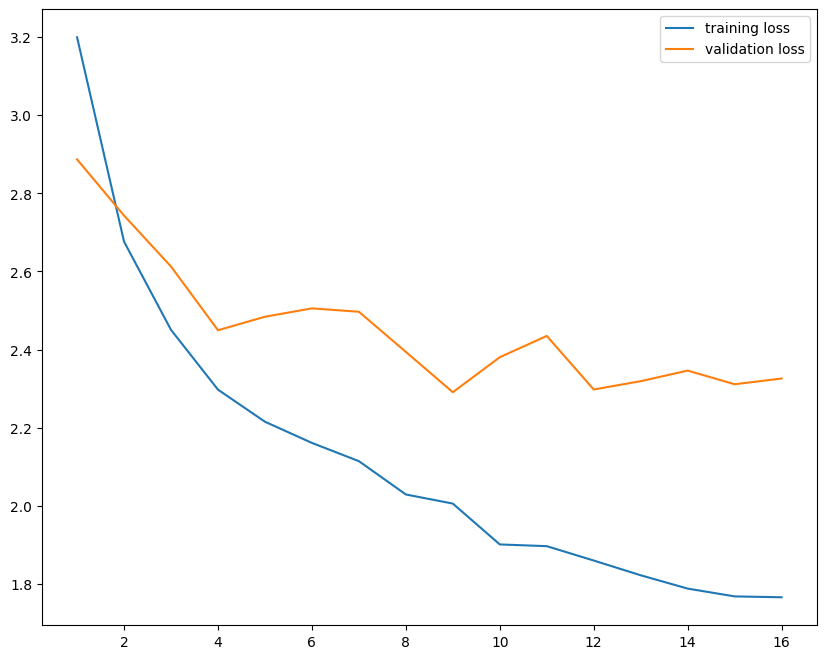

In [2]:
bird_model = models.resnet18()
bird_model.fc=nn.Linear(bird_model.fc.in_features,120)
bird_model.load_state_dict(torch.load('RestNet18_dog_model.pt'))

for param in bird_model.parameters():
    param.requires_grad = False

    
bird_model.fc=nn.Linear(bird_model.fc.in_features,25)

for param in bird_model.fc.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bird_model = bird_model.to(device)


mean = [0.4914, 0.4822, 0.4465] 
std = [0.2470, 0.2435, 0.2616] 
batch_size = 16
n_epochs = 100

train_transform = transforms.Compose([ 
transforms.Resize((224,224)), 
transforms.RandomCrop(224, padding=4), 
transforms.RandomHorizontalFlip(),
transforms.ToTensor(), 
transforms.Normalize(mean, std)
])

path='C:/Users/User/DeepLearning/Deep_Learning/Bird_Classification/HW2_Dataset/dataset_new'
all_train = datasets.ImageFolder(root = path, transform = train_transform)
train_size = int(0.9 * len(all_train ))
validation_size = len(all_train) - train_size
train_dataset, validation_dataset = random_split(all_train , [train_size, validation_size])

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3
)
val_loader = DataLoader(
    validation_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bird_model.parameters(), lr=1e-3)

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

def train(model, train_loader, optimizer, loss_fn):
    model.train()
    train_loss = 0.
    corrects=0
    total = 0
    for images, labels in tqdm(train_loader):
        optimizer.zero_grad() # step 1
        images = images.to(device)
        labels = labels.to(device)
        

        logits = model(images) # step 2 (forward pass)
        loss = loss_fn(logits, labels) # step 3 (compute loss)
        _, predictions = torch.max(logits, dim=1)
        corrects += predictions.eq(labels).sum().item()
        total += labels.size(0)
        
        loss.backward() # step 4 (backpropagation)
        optimizer.step()

        train_loss += loss.item()*images.size(0)
       
        
    train_loss = train_loss/len(train_loader.sampler)
    
    return train_loss, corrects/total    


@torch.no_grad()
def validate(model, valid_loader, loss_fn):
    model.eval()
    losses=0.
    corrects=0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            
                
            logits = model(images) # step 2 (forward pass)
            loss = loss_fn(logits, labels) # step 3 (compute loss)
            total += labels.size(0)
            
            _, predictions = torch.max(logits, dim=1)
            corrects += predictions.eq(labels).sum().item()
            
            losses += loss.item()*images.size(0)    
            
        valid_loss = losses/len(valid_loader.sampler)
    return valid_loss, corrects / total


# is_valid_available = True
# scheduler = lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.9 ** epoch)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0)

train_loss_list = []
valid_loss_list = []

early_stopper = EarlyStopper(patience=7)

for epoch in range(n_epochs):
    training_loss, training_accuracy = train(bird_model, train_loader, optimizer, loss_fn)
    valid_loss, valid_accuracy = validate(bird_model, val_loader, loss_fn)
    
    train_loss_list.append(training_loss)
    valid_loss_list.append(valid_loss)

    # if scheduler is not None and is_valid_available:
    #     scheduler.step(valid_loss)
    # elif scheduler is not None:
    #     scheduler.step()
    
    if early_stopper.early_stop(valid_loss):
        print(f"Epoch {epoch+1}/{n_epochs}: training accuracy: {training_accuracy}, valid accuracy: {valid_accuracy},train loss: {training_loss},valid loss:{valid_loss}") 
        break

fig, ax = plt.subplots(figsize=(10,8))

ax.plot(range(1, len(train_loss_list)+1), train_loss_list, label="training loss")
ax.plot(range(1, len(valid_loss_list)+1), valid_loss_list, label="validation loss")
ax.legend()        

In [12]:
bird_model = models.resnet18()
ct = 0
for child in bird_model.children():
    ct += 1
    if ct <= 10:
        print(child)

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fal

100%|██████████| 8/8 [00:06<00:00,  1.26it/s]

Epoch 22/100: training accuracy: 0.9509713228492137, valid accuracy: 0.5206611570247934,train loss: 0.14191084365798962,valid loss:2.197954554203128


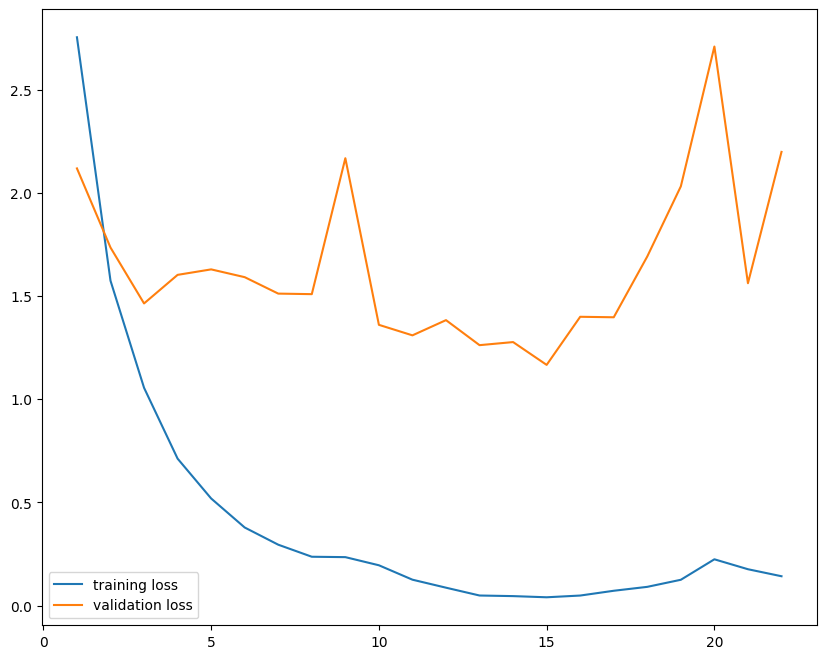

In [12]:
bird_model = models.resnet18()
bird_model.fc=nn.Linear(bird_model.fc.in_features,120)
bird_model.load_state_dict(torch.load('RestNet18_dog_model.pt'))

# for param in bird_model.parameters():
#     param.requires_grad = False
ct = 0
for child in bird_model.children():
    ct += 1
    if ct <= 1:
        for param in child.parameters():
            param.requires_grad = False
    
bird_model.fc=nn.Linear(bird_model.fc.in_features,25)

for param in bird_model.fc.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bird_model = bird_model.to(device)


mean = [0.4914, 0.4822, 0.4465] 
std = [0.2470, 0.2435, 0.2616] 
batch_size = 16
n_epochs = 100

train_transform = transforms.Compose([ 
transforms.Resize((224,224)), 
transforms.RandomCrop(224, padding=4), 
transforms.RandomHorizontalFlip(),
transforms.ToTensor(), 
transforms.Normalize(mean, std)
])

path='C:/Users/User/DeepLearning/Deep_Learning/Bird_Classification/HW2_Dataset/dataset_new'
all_train = datasets.ImageFolder(root = path, transform = train_transform)
train_size = int(0.9 * len(all_train ))
validation_size = len(all_train) - train_size
train_dataset, validation_dataset = random_split(all_train , [train_size, validation_size])

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3
)
val_loader = DataLoader(
    validation_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bird_model.parameters(), lr=1e-3)

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

def train(model, train_loader, optimizer, loss_fn):
    model.train()
    train_loss = 0.
    corrects=0
    total = 0
    for images, labels in tqdm(train_loader):
        optimizer.zero_grad() # step 1
        images = images.to(device)
        labels = labels.to(device)
        

        logits = model(images) # step 2 (forward pass)
        loss = loss_fn(logits, labels) # step 3 (compute loss)
        _, predictions = torch.max(logits, dim=1)
        corrects += predictions.eq(labels).sum().item()
        total += labels.size(0)
        
        loss.backward() # step 4 (backpropagation)
        optimizer.step()

        train_loss += loss.item()*images.size(0)
       
        
    train_loss = train_loss/len(train_loader.sampler)
    
    return train_loss, corrects/total    


@torch.no_grad()
def validate(model, valid_loader, loss_fn):
    model.eval()
    losses=0.
    corrects=0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            
                
            logits = model(images) # step 2 (forward pass)
            loss = loss_fn(logits, labels) # step 3 (compute loss)
            total += labels.size(0)
            
            _, predictions = torch.max(logits, dim=1)
            corrects += predictions.eq(labels).sum().item()
            
            losses += loss.item()*images.size(0)    
            
        valid_loss = losses/len(valid_loader.sampler)
    return valid_loss, corrects / total


# is_valid_available = True
# scheduler = lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.9 ** epoch)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0)

train_loss_list = []
valid_loss_list = []

early_stopper = EarlyStopper(patience=7)

for epoch in range(n_epochs):
    training_loss, training_accuracy = train(bird_model, train_loader, optimizer, loss_fn)
    valid_loss, valid_accuracy = validate(bird_model, val_loader, loss_fn)
    
    train_loss_list.append(training_loss)
    valid_loss_list.append(valid_loss)

    # if scheduler is not None and is_valid_available:
    #     scheduler.step(valid_loss)
    # elif scheduler is not None:
    #     scheduler.step()
    
    if early_stopper.early_stop(valid_loss):
        print(f"Epoch {epoch+1}/{n_epochs}: training accuracy: {training_accuracy}, valid accuracy: {valid_accuracy},train loss: {training_loss},valid loss:{valid_loss}") 
        break

fig, ax = plt.subplots(figsize=(10,8))

ax.plot(range(1, len(train_loss_list)+1), train_loss_list, label="training loss")
ax.plot(range(1, len(valid_loss_list)+1), valid_loss_list, label="validation loss")
ax.legend()        

100%|██████████| 8/8 [00:06<00:00,  1.27it/s]

Epoch 14/100: training accuracy: 0.9685476410730804, valid accuracy: 0.6198347107438017,train loss: 0.10280561384768204,valid loss:1.621262803550594


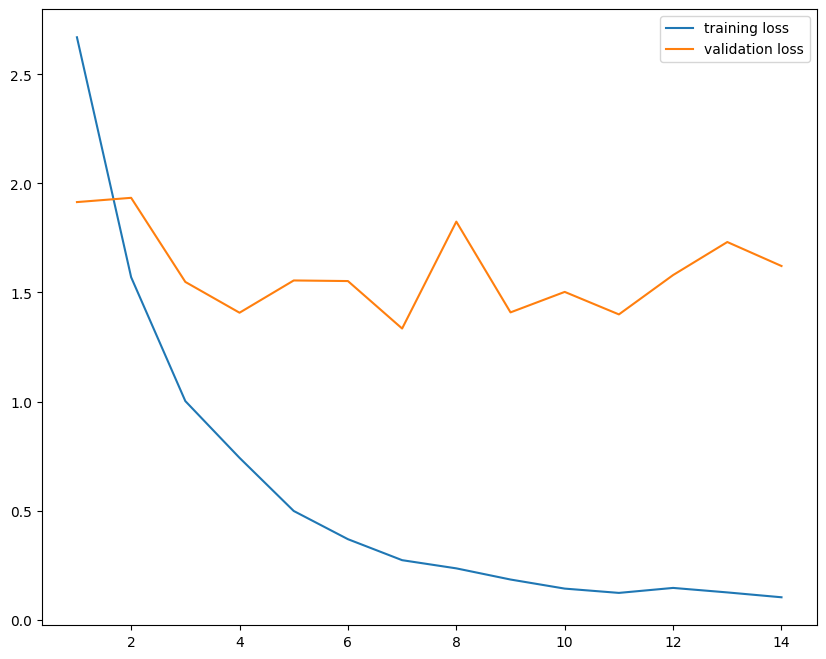

In [13]:
bird_model = models.resnet18()
bird_model.fc=nn.Linear(bird_model.fc.in_features,120)
bird_model.load_state_dict(torch.load('RestNet18_dog_model.pt'))

# for param in bird_model.parameters():
#     param.requires_grad = False
ct = 0
for child in bird_model.children():
    ct += 1
    if ct <= 2:
        for param in child.parameters():
            param.requires_grad = False
    
bird_model.fc=nn.Linear(bird_model.fc.in_features,25)

for param in bird_model.fc.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bird_model = bird_model.to(device)


mean = [0.4914, 0.4822, 0.4465] 
std = [0.2470, 0.2435, 0.2616] 
batch_size = 16
n_epochs = 100

train_transform = transforms.Compose([ 
transforms.Resize((224,224)), 
transforms.RandomCrop(224, padding=4), 
transforms.RandomHorizontalFlip(),
transforms.ToTensor(), 
transforms.Normalize(mean, std)
])

path='C:/Users/User/DeepLearning/Deep_Learning/Bird_Classification/HW2_Dataset/dataset_new'
all_train = datasets.ImageFolder(root = path, transform = train_transform)
train_size = int(0.9 * len(all_train ))
validation_size = len(all_train) - train_size
train_dataset, validation_dataset = random_split(all_train , [train_size, validation_size])

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3
)
val_loader = DataLoader(
    validation_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bird_model.parameters(), lr=1e-3)

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

def train(model, train_loader, optimizer, loss_fn):
    model.train()
    train_loss = 0.
    corrects=0
    total = 0
    for images, labels in tqdm(train_loader):
        optimizer.zero_grad() # step 1
        images = images.to(device)
        labels = labels.to(device)
        

        logits = model(images) # step 2 (forward pass)
        loss = loss_fn(logits, labels) # step 3 (compute loss)
        _, predictions = torch.max(logits, dim=1)
        corrects += predictions.eq(labels).sum().item()
        total += labels.size(0)
        
        loss.backward() # step 4 (backpropagation)
        optimizer.step()

        train_loss += loss.item()*images.size(0)
       
        
    train_loss = train_loss/len(train_loader.sampler)
    
    return train_loss, corrects/total    


@torch.no_grad()
def validate(model, valid_loader, loss_fn):
    model.eval()
    losses=0.
    corrects=0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            
                
            logits = model(images) # step 2 (forward pass)
            loss = loss_fn(logits, labels) # step 3 (compute loss)
            total += labels.size(0)
            
            _, predictions = torch.max(logits, dim=1)
            corrects += predictions.eq(labels).sum().item()
            
            losses += loss.item()*images.size(0)    
            
        valid_loss = losses/len(valid_loader.sampler)
    return valid_loss, corrects / total


# is_valid_available = True
# scheduler = lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.9 ** epoch)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0)

train_loss_list = []
valid_loss_list = []

early_stopper = EarlyStopper(patience=7)

for epoch in range(n_epochs):
    training_loss, training_accuracy = train(bird_model, train_loader, optimizer, loss_fn)
    valid_loss, valid_accuracy = validate(bird_model, val_loader, loss_fn)
    
    train_loss_list.append(training_loss)
    valid_loss_list.append(valid_loss)

    # if scheduler is not None and is_valid_available:
    #     scheduler.step(valid_loss)
    # elif scheduler is not None:
    #     scheduler.step()
    
    if early_stopper.early_stop(valid_loss):
        print(f"Epoch {epoch+1}/{n_epochs}: training accuracy: {training_accuracy}, valid accuracy: {valid_accuracy},train loss: {training_loss},valid loss:{valid_loss}") 
        break

fig, ax = plt.subplots(figsize=(10,8))

ax.plot(range(1, len(train_loss_list)+1), train_loss_list, label="training loss")
ax.plot(range(1, len(valid_loss_list)+1), valid_loss_list, label="validation loss")
ax.legend()        

100%|██████████| 8/8 [00:07<00:00,  1.04it/s]

Epoch 16/100: training accuracy: 0.9759481961147086, valid accuracy: 0.6363636363636364,train loss: 0.08390897017568488,valid loss:1.3309823116980308


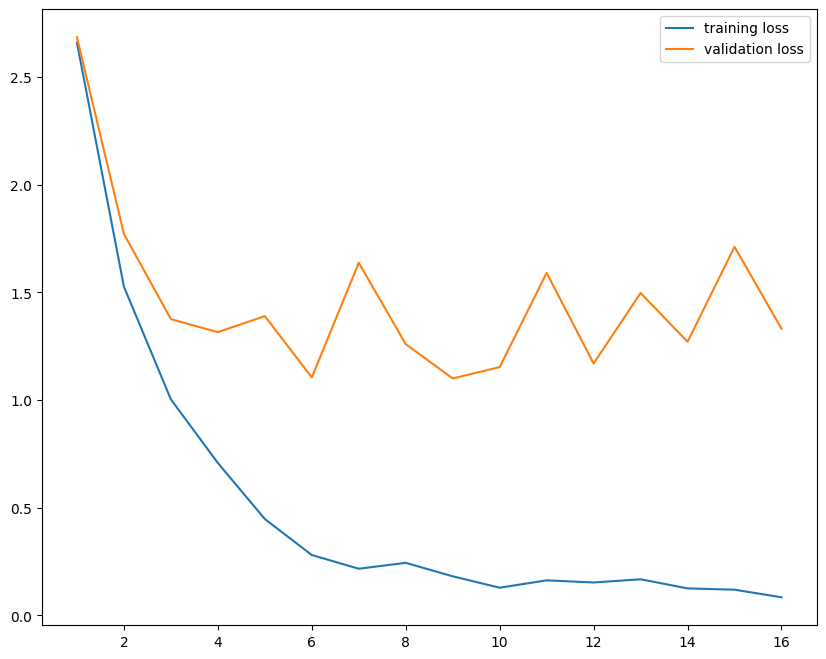

In [3]:
bird_model = models.resnet18()
bird_model.fc=nn.Linear(bird_model.fc.in_features,120)
bird_model.load_state_dict(torch.load('RestNet18_dog_model.pt'))

# for param in bird_model.parameters():
#     param.requires_grad = False
ct = 0
for child in bird_model.children():
    ct += 1
    if ct <= 3:
        for param in child.parameters():
            param.requires_grad = False
    
bird_model.fc=nn.Linear(bird_model.fc.in_features,25)

for param in bird_model.fc.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bird_model = bird_model.to(device)


mean = [0.4914, 0.4822, 0.4465] 
std = [0.2470, 0.2435, 0.2616] 
batch_size = 16
n_epochs = 100

train_transform = transforms.Compose([ 
transforms.Resize((224,224)), 
transforms.RandomCrop(224, padding=4), 
transforms.RandomHorizontalFlip(),
transforms.ToTensor(), 
transforms.Normalize(mean, std)
])

path='C:/Users/User/DeepLearning/Deep_Learning/Bird_Classification/HW2_Dataset/dataset_new'
all_train = datasets.ImageFolder(root = path, transform = train_transform)
train_size = int(0.9 * len(all_train ))
validation_size = len(all_train) - train_size
train_dataset, validation_dataset = random_split(all_train , [train_size, validation_size])

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3
)
val_loader = DataLoader(
    validation_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bird_model.parameters(), lr=1e-3)

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

def train(model, train_loader, optimizer, loss_fn):
    model.train()
    train_loss = 0.
    corrects=0
    total = 0
    for images, labels in tqdm(train_loader):
        optimizer.zero_grad() # step 1
        images = images.to(device)
        labels = labels.to(device)
        

        logits = model(images) # step 2 (forward pass)
        loss = loss_fn(logits, labels) # step 3 (compute loss)
        _, predictions = torch.max(logits, dim=1)
        corrects += predictions.eq(labels).sum().item()
        total += labels.size(0)
        
        loss.backward() # step 4 (backpropagation)
        optimizer.step()

        train_loss += loss.item()*images.size(0)
       
        
    train_loss = train_loss/len(train_loader.sampler)
    
    return train_loss, corrects/total    


@torch.no_grad()
def validate(model, valid_loader, loss_fn):
    model.eval()
    losses=0.
    corrects=0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            
                
            logits = model(images) # step 2 (forward pass)
            loss = loss_fn(logits, labels) # step 3 (compute loss)
            total += labels.size(0)
            
            _, predictions = torch.max(logits, dim=1)
            corrects += predictions.eq(labels).sum().item()
            
            losses += loss.item()*images.size(0)    
            
        valid_loss = losses/len(valid_loader.sampler)
    return valid_loss, corrects / total


# is_valid_available = True
# scheduler = lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.9 ** epoch)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0)

train_loss_list = []
valid_loss_list = []

early_stopper = EarlyStopper(patience=7)

for epoch in range(n_epochs):
    training_loss, training_accuracy = train(bird_model, train_loader, optimizer, loss_fn)
    valid_loss, valid_accuracy = validate(bird_model, val_loader, loss_fn)
    
    train_loss_list.append(training_loss)
    valid_loss_list.append(valid_loss)

    # if scheduler is not None and is_valid_available:
    #     scheduler.step(valid_loss)
    # elif scheduler is not None:
    #     scheduler.step()
    
    if early_stopper.early_stop(valid_loss):
        print(f"Epoch {epoch+1}/{n_epochs}: training accuracy: {training_accuracy}, valid accuracy: {valid_accuracy},train loss: {training_loss},valid loss:{valid_loss}") 
        break

fig, ax = plt.subplots(figsize=(10,8))

ax.plot(range(1, len(train_loss_list)+1), train_loss_list, label="training loss")
ax.plot(range(1, len(valid_loss_list)+1), valid_loss_list, label="validation loss")
ax.legend()        

100%|██████████| 8/8 [00:06<00:00,  1.23it/s]

Epoch 18/100: training accuracy: 0.9417206290471786, valid accuracy: 0.6115702479338843,train loss: 0.1986192507974314,valid loss:1.7525750270559768


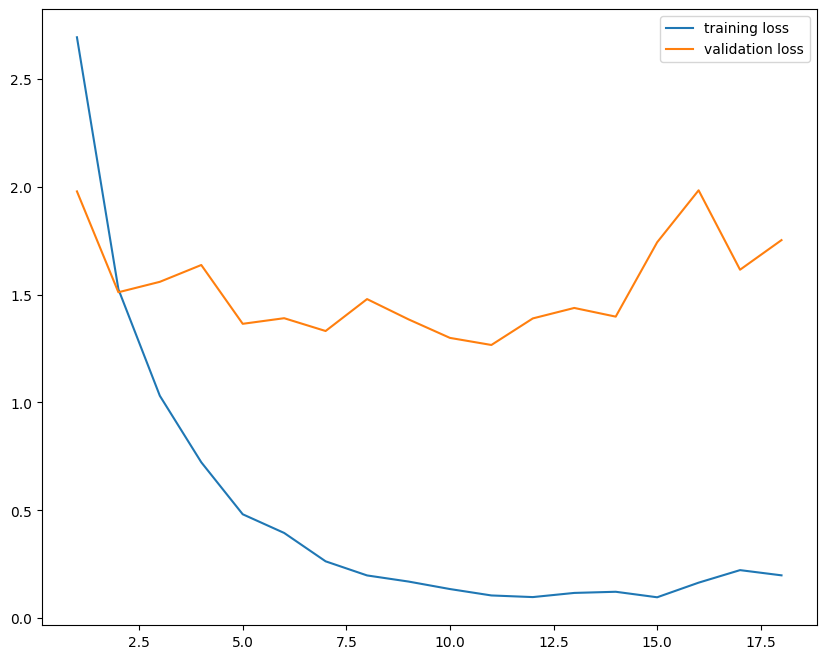

In [14]:
bird_model = models.resnet18()
bird_model.fc=nn.Linear(bird_model.fc.in_features,120)
bird_model.load_state_dict(torch.load('RestNet18_dog_model.pt'))

# for param in bird_model.parameters():
#     param.requires_grad = False
ct = 0
for child in bird_model.children():
    ct += 1
    if ct <= 4:
        for param in child.parameters():
            param.requires_grad = False
    
bird_model.fc=nn.Linear(bird_model.fc.in_features,25)

for param in bird_model.fc.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bird_model = bird_model.to(device)


mean = [0.4914, 0.4822, 0.4465] 
std = [0.2470, 0.2435, 0.2616] 
batch_size = 16
n_epochs = 100

train_transform = transforms.Compose([ 
transforms.Resize((224,224)), 
transforms.RandomCrop(224, padding=4), 
transforms.RandomHorizontalFlip(),
transforms.ToTensor(), 
transforms.Normalize(mean, std)
])

path='C:/Users/User/DeepLearning/Deep_Learning/Bird_Classification/HW2_Dataset/dataset_new'
all_train = datasets.ImageFolder(root = path, transform = train_transform)
train_size = int(0.9 * len(all_train ))
validation_size = len(all_train) - train_size
train_dataset, validation_dataset = random_split(all_train , [train_size, validation_size])

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3
)
val_loader = DataLoader(
    validation_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bird_model.parameters(), lr=1e-3)

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

def train(model, train_loader, optimizer, loss_fn):
    model.train()
    train_loss = 0.
    corrects=0
    total = 0
    for images, labels in tqdm(train_loader):
        optimizer.zero_grad() # step 1
        images = images.to(device)
        labels = labels.to(device)
        

        logits = model(images) # step 2 (forward pass)
        loss = loss_fn(logits, labels) # step 3 (compute loss)
        _, predictions = torch.max(logits, dim=1)
        corrects += predictions.eq(labels).sum().item()
        total += labels.size(0)
        
        loss.backward() # step 4 (backpropagation)
        optimizer.step()

        train_loss += loss.item()*images.size(0)
       
        
    train_loss = train_loss/len(train_loader.sampler)
    
    return train_loss, corrects/total    


@torch.no_grad()
def validate(model, valid_loader, loss_fn):
    model.eval()
    losses=0.
    corrects=0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            
                
            logits = model(images) # step 2 (forward pass)
            loss = loss_fn(logits, labels) # step 3 (compute loss)
            total += labels.size(0)
            
            _, predictions = torch.max(logits, dim=1)
            corrects += predictions.eq(labels).sum().item()
            
            losses += loss.item()*images.size(0)    
            
        valid_loss = losses/len(valid_loader.sampler)
    return valid_loss, corrects / total


# is_valid_available = True
# scheduler = lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.9 ** epoch)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0)

train_loss_list = []
valid_loss_list = []

early_stopper = EarlyStopper(patience=7)

for epoch in range(n_epochs):
    training_loss, training_accuracy = train(bird_model, train_loader, optimizer, loss_fn)
    valid_loss, valid_accuracy = validate(bird_model, val_loader, loss_fn)
    
    train_loss_list.append(training_loss)
    valid_loss_list.append(valid_loss)

    # if scheduler is not None and is_valid_available:
    #     scheduler.step(valid_loss)
    # elif scheduler is not None:
    #     scheduler.step()
    
    if early_stopper.early_stop(valid_loss):
        print(f"Epoch {epoch+1}/{n_epochs}: training accuracy: {training_accuracy}, valid accuracy: {valid_accuracy},train loss: {training_loss},valid loss:{valid_loss}") 
        break

fig, ax = plt.subplots(figsize=(10,8))

ax.plot(range(1, len(train_loss_list)+1), train_loss_list, label="training loss")
ax.plot(range(1, len(valid_loss_list)+1), valid_loss_list, label="validation loss")
ax.legend()        

100%|██████████| 8/8 [00:06<00:00,  1.25it/s]

Epoch 24/100: training accuracy: 0.9750231267345051, valid accuracy: 0.7107438016528925,train loss: 0.08694916157866936,valid loss:1.3607745934123836


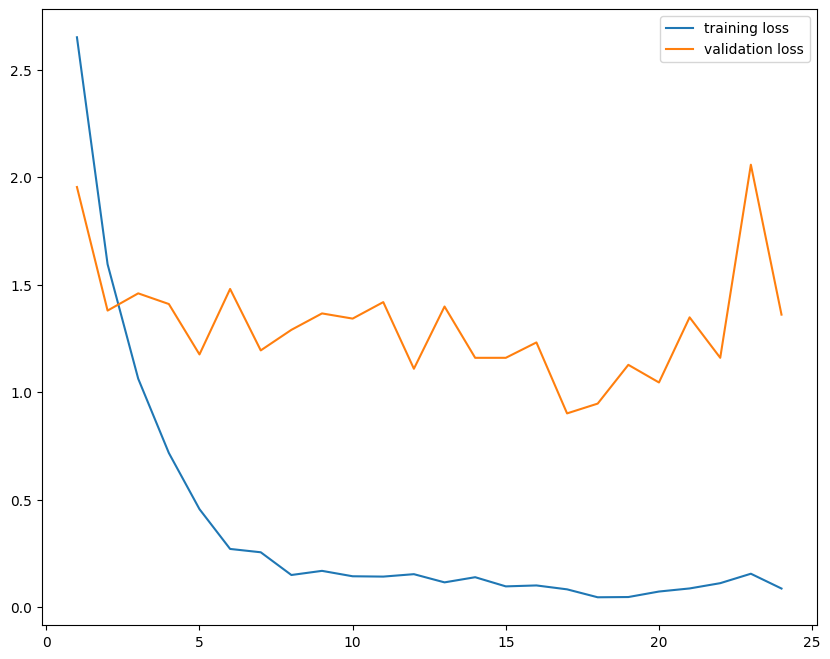

In [15]:
bird_model = models.resnet18()
bird_model.fc=nn.Linear(bird_model.fc.in_features,120)
bird_model.load_state_dict(torch.load('RestNet18_dog_model.pt'))

# for param in bird_model.parameters():
#     param.requires_grad = False
ct = 0
for child in bird_model.children():
    ct += 1
    if ct <= 5:
        for param in child.parameters():
            param.requires_grad = False
    
bird_model.fc=nn.Linear(bird_model.fc.in_features,25)

for param in bird_model.fc.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bird_model = bird_model.to(device)


mean = [0.4914, 0.4822, 0.4465] 
std = [0.2470, 0.2435, 0.2616] 
batch_size = 16
n_epochs = 100

train_transform = transforms.Compose([ 
transforms.Resize((224,224)), 
transforms.RandomCrop(224, padding=4), 
transforms.RandomHorizontalFlip(),
transforms.ToTensor(), 
transforms.Normalize(mean, std)
])

path='C:/Users/User/DeepLearning/Deep_Learning/Bird_Classification/HW2_Dataset/dataset_new'
all_train = datasets.ImageFolder(root = path, transform = train_transform)
train_size = int(0.9 * len(all_train ))
validation_size = len(all_train) - train_size
train_dataset, validation_dataset = random_split(all_train , [train_size, validation_size])

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3
)
val_loader = DataLoader(
    validation_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bird_model.parameters(), lr=1e-3)

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

def train(model, train_loader, optimizer, loss_fn):
    model.train()
    train_loss = 0.
    corrects=0
    total = 0
    for images, labels in tqdm(train_loader):
        optimizer.zero_grad() # step 1
        images = images.to(device)
        labels = labels.to(device)
        

        logits = model(images) # step 2 (forward pass)
        loss = loss_fn(logits, labels) # step 3 (compute loss)
        _, predictions = torch.max(logits, dim=1)
        corrects += predictions.eq(labels).sum().item()
        total += labels.size(0)
        
        loss.backward() # step 4 (backpropagation)
        optimizer.step()

        train_loss += loss.item()*images.size(0)
       
        
    train_loss = train_loss/len(train_loader.sampler)
    
    return train_loss, corrects/total    


@torch.no_grad()
def validate(model, valid_loader, loss_fn):
    model.eval()
    losses=0.
    corrects=0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            
                
            logits = model(images) # step 2 (forward pass)
            loss = loss_fn(logits, labels) # step 3 (compute loss)
            total += labels.size(0)
            
            _, predictions = torch.max(logits, dim=1)
            corrects += predictions.eq(labels).sum().item()
            
            losses += loss.item()*images.size(0)    
            
        valid_loss = losses/len(valid_loader.sampler)
    return valid_loss, corrects / total


# is_valid_available = True
# scheduler = lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.9 ** epoch)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0)

train_loss_list = []
valid_loss_list = []

early_stopper = EarlyStopper(patience=7)

for epoch in range(n_epochs):
    training_loss, training_accuracy = train(bird_model, train_loader, optimizer, loss_fn)
    valid_loss, valid_accuracy = validate(bird_model, val_loader, loss_fn)
    
    train_loss_list.append(training_loss)
    valid_loss_list.append(valid_loss)

    # if scheduler is not None and is_valid_available:
    #     scheduler.step(valid_loss)
    # elif scheduler is not None:
    #     scheduler.step()
    
    if early_stopper.early_stop(valid_loss):
        print(f"Epoch {epoch+1}/{n_epochs}: training accuracy: {training_accuracy}, valid accuracy: {valid_accuracy},train loss: {training_loss},valid loss:{valid_loss}") 
        break

fig, ax = plt.subplots(figsize=(10,8))

ax.plot(range(1, len(train_loss_list)+1), train_loss_list, label="training loss")
ax.plot(range(1, len(valid_loss_list)+1), valid_loss_list, label="validation loss")
ax.legend()        

100%|██████████| 8/8 [00:06<00:00,  1.18it/s]

Epoch 16/100: training accuracy: 0.9814986123959297, valid accuracy: 0.5537190082644629,train loss: 0.06513972584999043,valid loss:2.0229746664851165


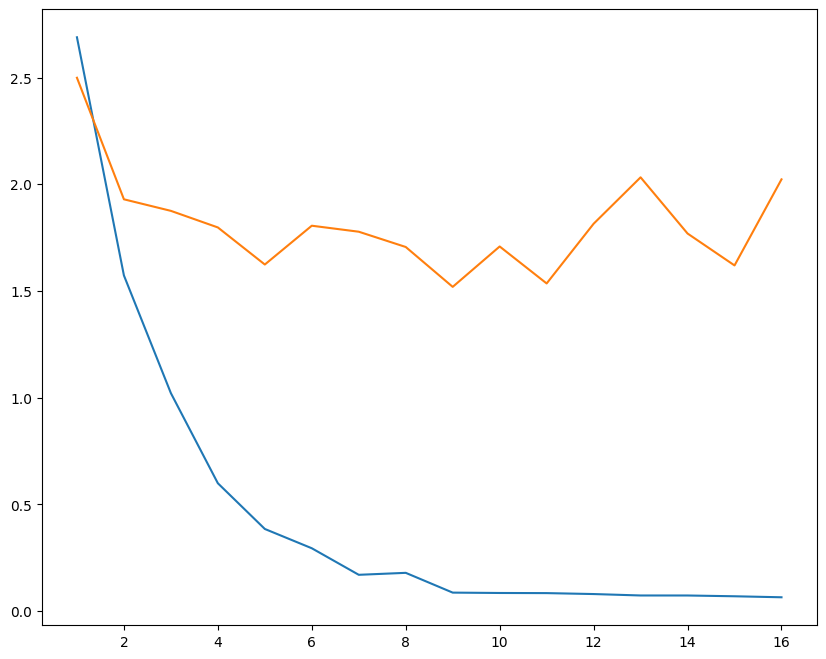

In [4]:
bird_model = models.resnet18()
bird_model.fc=nn.Linear(bird_model.fc.in_features,120)
bird_model.load_state_dict(torch.load('RestNet18_dog_model.pt'))

# for param in bird_model.parameters():
#     param.requires_grad = False
ct = 0
for child in bird_model.children():
    ct += 1
    if ct <= 6:
        for param in child.parameters():
            param.requires_grad = False
    
bird_model.fc=nn.Linear(bird_model.fc.in_features,25)

for param in bird_model.fc.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bird_model = bird_model.to(device)


mean = [0.4914, 0.4822, 0.4465] 
std = [0.2470, 0.2435, 0.2616] 
batch_size = 16
n_epochs = 100

train_transform = transforms.Compose([ 
transforms.Resize((224,224)), 
transforms.RandomCrop(224, padding=4), 
transforms.RandomHorizontalFlip(),
transforms.ToTensor(), 
transforms.Normalize(mean, std)
])

path='C:/Users/User/DeepLearning/Deep_Learning/Bird_Classification/HW2_Dataset/dataset_new'
all_train = datasets.ImageFolder(root = path, transform = train_transform)
train_size = int(0.9 * len(all_train ))
validation_size = len(all_train) - train_size
train_dataset, validation_dataset = random_split(all_train , [train_size, validation_size])

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3
)
val_loader = DataLoader(
    validation_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bird_model.parameters(), lr=1e-3)

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

def train(model, train_loader, optimizer, loss_fn):
    model.train()
    train_loss = 0.
    corrects=0
    total = 0
    for images, labels in tqdm(train_loader):
        optimizer.zero_grad() # step 1
        images = images.to(device)
        labels = labels.to(device)
        

        logits = model(images) # step 2 (forward pass)
        loss = loss_fn(logits, labels) # step 3 (compute loss)
        _, predictions = torch.max(logits, dim=1)
        corrects += predictions.eq(labels).sum().item()
        total += labels.size(0)
        
        loss.backward() # step 4 (backpropagation)
        optimizer.step()

        train_loss += loss.item()*images.size(0)
       
        
    train_loss = train_loss/len(train_loader.sampler)
    
    return train_loss, corrects/total    


@torch.no_grad()
def validate(model, valid_loader, loss_fn):
    model.eval()
    losses=0.
    corrects=0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            
                
            logits = model(images) # step 2 (forward pass)
            loss = loss_fn(logits, labels) # step 3 (compute loss)
            total += labels.size(0)
            
            _, predictions = torch.max(logits, dim=1)
            corrects += predictions.eq(labels).sum().item()
            
            losses += loss.item()*images.size(0)    
            
        valid_loss = losses/len(valid_loader.sampler)
    return valid_loss, corrects / total


# is_valid_available = True
# scheduler = lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.9 ** epoch)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0)

train_loss_list = []
valid_loss_list = []

early_stopper = EarlyStopper(patience=7)

for epoch in range(n_epochs):
    training_loss, training_accuracy = train(bird_model, train_loader, optimizer, loss_fn)
    valid_loss, valid_accuracy = validate(bird_model, val_loader, loss_fn)
    
    train_loss_list.append(training_loss)
    valid_loss_list.append(valid_loss)

    # if scheduler is not None and is_valid_available:
    #     scheduler.step(valid_loss)
    # elif scheduler is not None:
    #     scheduler.step()

    if early_stopper.early_stop(valid_loss):
        print(f"Epoch {epoch+1}/{n_epochs}: training accuracy: {training_accuracy}, valid accuracy: {valid_accuracy},train loss: {training_loss},valid loss:{valid_loss}") 
        break

fig, ax = plt.subplots(figsize=(10,8))

ax.plot(range(1, len(train_loss_list)+1), train_loss_list, label="training loss")
ax.plot(range(1, len(valid_loss_list)+1), valid_loss_list, label="validation loss")

100%|██████████| 8/8 [00:06<00:00,  1.24it/s]

Epoch 14/100: training accuracy: 0.9916743755781684, valid accuracy: 0.5454545454545454,train loss: 0.05000713035450502,valid loss:1.7433659301316442


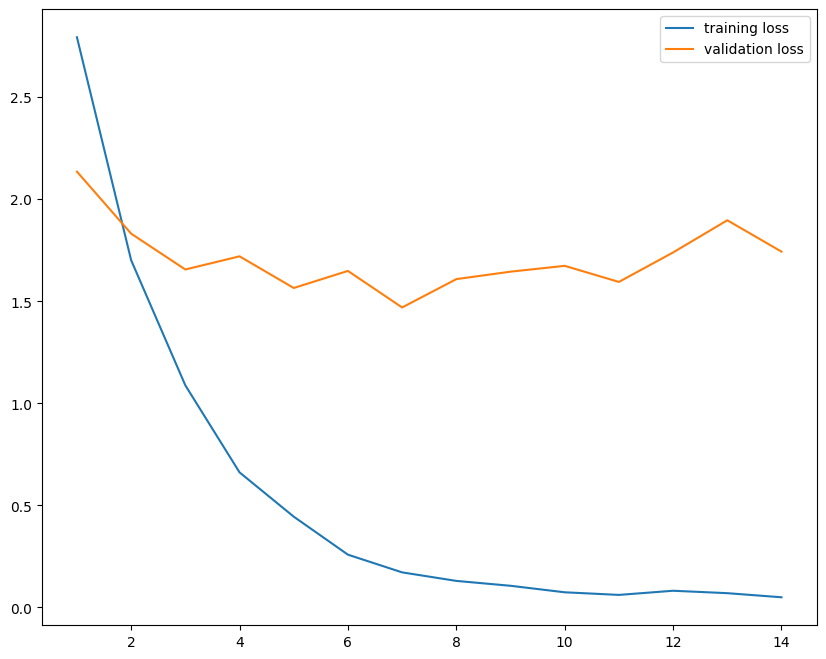

In [16]:
bird_model = models.resnet18()
bird_model.fc=nn.Linear(bird_model.fc.in_features,120)
bird_model.load_state_dict(torch.load('RestNet18_dog_model.pt'))

# for param in bird_model.parameters():
#     param.requires_grad = False
ct = 0
for child in bird_model.children():
    ct += 1
    if ct <= 7:
        for param in child.parameters():
            param.requires_grad = False
    
bird_model.fc=nn.Linear(bird_model.fc.in_features,25)

for param in bird_model.fc.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bird_model = bird_model.to(device)


mean = [0.4914, 0.4822, 0.4465] 
std = [0.2470, 0.2435, 0.2616] 
batch_size = 16
n_epochs = 100

train_transform = transforms.Compose([ 
transforms.Resize((224,224)), 
transforms.RandomCrop(224, padding=4), 
transforms.RandomHorizontalFlip(),
transforms.ToTensor(), 
transforms.Normalize(mean, std)
])

path='C:/Users/User/DeepLearning/Deep_Learning/Bird_Classification/HW2_Dataset/dataset_new'
all_train = datasets.ImageFolder(root = path, transform = train_transform)
train_size = int(0.9 * len(all_train ))
validation_size = len(all_train) - train_size
train_dataset, validation_dataset = random_split(all_train , [train_size, validation_size])

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3
)
val_loader = DataLoader(
    validation_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bird_model.parameters(), lr=1e-3)

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

def train(model, train_loader, optimizer, loss_fn):
    model.train()
    train_loss = 0.
    corrects=0
    total = 0
    for images, labels in tqdm(train_loader):
        optimizer.zero_grad() # step 1
        images = images.to(device)
        labels = labels.to(device)
        

        logits = model(images) # step 2 (forward pass)
        loss = loss_fn(logits, labels) # step 3 (compute loss)
        _, predictions = torch.max(logits, dim=1)
        corrects += predictions.eq(labels).sum().item()
        total += labels.size(0)
        
        loss.backward() # step 4 (backpropagation)
        optimizer.step()

        train_loss += loss.item()*images.size(0)
       
        
    train_loss = train_loss/len(train_loader.sampler)
    
    return train_loss, corrects/total    


@torch.no_grad()
def validate(model, valid_loader, loss_fn):
    model.eval()
    losses=0.
    corrects=0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            
                
            logits = model(images) # step 2 (forward pass)
            loss = loss_fn(logits, labels) # step 3 (compute loss)
            total += labels.size(0)
            
            _, predictions = torch.max(logits, dim=1)
            corrects += predictions.eq(labels).sum().item()
            
            losses += loss.item()*images.size(0)    
            
        valid_loss = losses/len(valid_loader.sampler)
    return valid_loss, corrects / total


# is_valid_available = True
# scheduler = lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.9 ** epoch)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0)

train_loss_list = []
valid_loss_list = []

early_stopper = EarlyStopper(patience=7)

for epoch in range(n_epochs):
    training_loss, training_accuracy = train(bird_model, train_loader, optimizer, loss_fn)
    valid_loss, valid_accuracy = validate(bird_model, val_loader, loss_fn)
    
    train_loss_list.append(training_loss)
    valid_loss_list.append(valid_loss)

    # if scheduler is not None and is_valid_available:
    #     scheduler.step(valid_loss)
    # elif scheduler is not None:
    #     scheduler.step()
    
    if early_stopper.early_stop(valid_loss):
        print(f"Epoch {epoch+1}/{n_epochs}: training accuracy: {training_accuracy}, valid accuracy: {valid_accuracy},train loss: {training_loss},valid loss:{valid_loss}") 
        break

fig, ax = plt.subplots(figsize=(10,8))

ax.plot(range(1, len(train_loss_list)+1), train_loss_list, label="training loss")
ax.plot(range(1, len(valid_loss_list)+1), valid_loss_list, label="validation loss")
ax.legend()        

100%|██████████| 8/8 [00:06<00:00,  1.26it/s]

Epoch 26/100: training accuracy: 0.5319148936170213, valid accuracy: 0.4049586776859504,train loss: 1.6217393539880405,valid loss:2.138495293530551


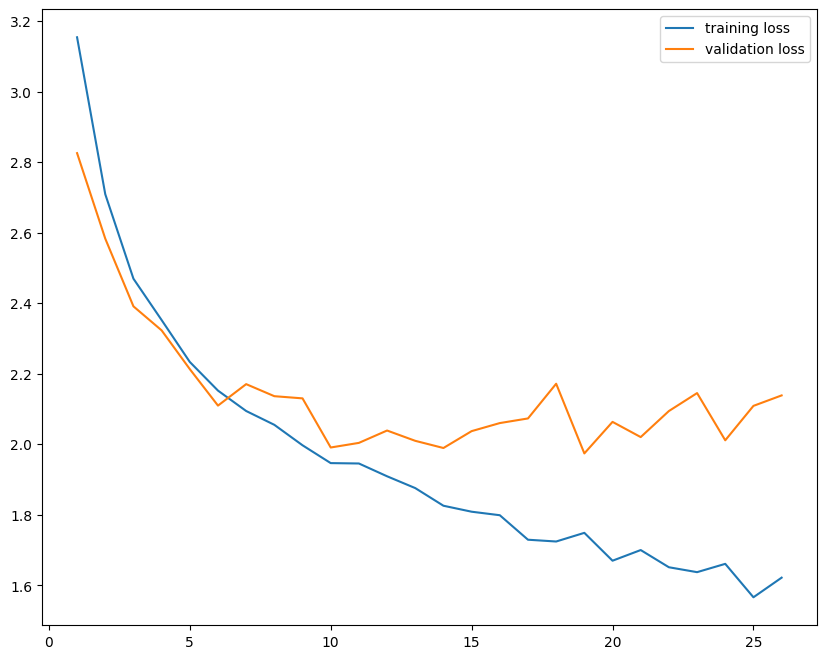

In [17]:
bird_model = models.resnet18()
bird_model.fc=nn.Linear(bird_model.fc.in_features,120)
bird_model.load_state_dict(torch.load('RestNet18_dog_model.pt'))

# for param in bird_model.parameters():
#     param.requires_grad = False
ct = 0
for child in bird_model.children():
    ct += 1
    if ct <= 8:
        for param in child.parameters():
            param.requires_grad = False
    
bird_model.fc=nn.Linear(bird_model.fc.in_features,25)

for param in bird_model.fc.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bird_model = bird_model.to(device)


mean = [0.4914, 0.4822, 0.4465] 
std = [0.2470, 0.2435, 0.2616] 
batch_size = 16
n_epochs = 100

train_transform = transforms.Compose([ 
transforms.Resize((224,224)), 
transforms.RandomCrop(224, padding=4), 
transforms.RandomHorizontalFlip(),
transforms.ToTensor(), 
transforms.Normalize(mean, std)
])

path='C:/Users/User/DeepLearning/Deep_Learning/Bird_Classification/HW2_Dataset/dataset_new'
all_train = datasets.ImageFolder(root = path, transform = train_transform)
train_size = int(0.9 * len(all_train ))
validation_size = len(all_train) - train_size
train_dataset, validation_dataset = random_split(all_train , [train_size, validation_size])

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3
)
val_loader = DataLoader(
    validation_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bird_model.parameters(), lr=1e-3)

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

def train(model, train_loader, optimizer, loss_fn):
    model.train()
    train_loss = 0.
    corrects=0
    total = 0
    for images, labels in tqdm(train_loader):
        optimizer.zero_grad() # step 1
        images = images.to(device)
        labels = labels.to(device)
        

        logits = model(images) # step 2 (forward pass)
        loss = loss_fn(logits, labels) # step 3 (compute loss)
        _, predictions = torch.max(logits, dim=1)
        corrects += predictions.eq(labels).sum().item()
        total += labels.size(0)
        
        loss.backward() # step 4 (backpropagation)
        optimizer.step()

        train_loss += loss.item()*images.size(0)
       
        
    train_loss = train_loss/len(train_loader.sampler)
    
    return train_loss, corrects/total    


@torch.no_grad()
def validate(model, valid_loader, loss_fn):
    model.eval()
    losses=0.
    corrects=0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            
                
            logits = model(images) # step 2 (forward pass)
            loss = loss_fn(logits, labels) # step 3 (compute loss)
            total += labels.size(0)
            
            _, predictions = torch.max(logits, dim=1)
            corrects += predictions.eq(labels).sum().item()
            
            losses += loss.item()*images.size(0)    
            
        valid_loss = losses/len(valid_loader.sampler)
    return valid_loss, corrects / total


# is_valid_available = True
# scheduler = lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.9 ** epoch)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0)

train_loss_list = []
valid_loss_list = []

early_stopper = EarlyStopper(patience=7)

for epoch in range(n_epochs):
    training_loss, training_accuracy = train(bird_model, train_loader, optimizer, loss_fn)
    valid_loss, valid_accuracy = validate(bird_model, val_loader, loss_fn)
    
    train_loss_list.append(training_loss)
    valid_loss_list.append(valid_loss)

    # if scheduler is not None and is_valid_available:
    #     scheduler.step(valid_loss)
    # elif scheduler is not None:
    #     scheduler.step()
    
    if early_stopper.early_stop(valid_loss):
        print(f"Epoch {epoch+1}/{n_epochs}: training accuracy: {training_accuracy}, valid accuracy: {valid_accuracy},train loss: {training_loss},valid loss:{valid_loss}") 
        break

fig, ax = plt.subplots(figsize=(10,8))

ax.plot(range(1, len(train_loss_list)+1), train_loss_list, label="training loss")
ax.plot(range(1, len(valid_loss_list)+1), valid_loss_list, label="validation loss")
ax.legend()        

100%|██████████| 8/8 [00:06<00:00,  1.28it/s]

Epoch 24/100: training accuracy: 0.5328399629972248, valid accuracy: 0.32231404958677684,train loss: 1.5622530424627963,valid loss:2.438593462479016


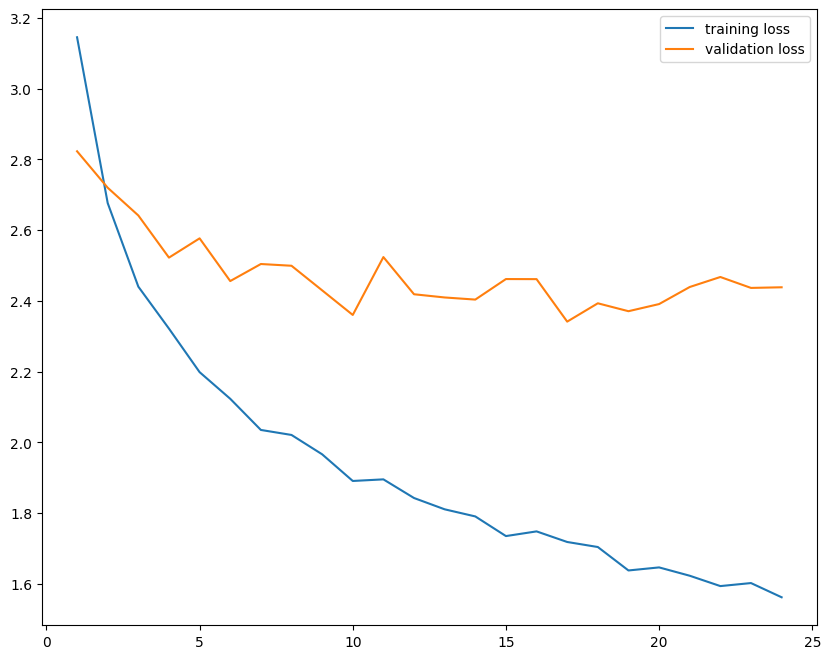

In [11]:
bird_model = models.resnet18()
bird_model.fc=nn.Linear(bird_model.fc.in_features,120)
bird_model.load_state_dict(torch.load('RestNet18_dog_model.pt'))

# for param in bird_model.parameters():
#     param.requires_grad = False
ct = 0
for child in bird_model.children():
    ct += 1
    if ct <= 9:
        for param in child.parameters():
            param.requires_grad = False
    
bird_model.fc=nn.Linear(bird_model.fc.in_features,25)

for param in bird_model.fc.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bird_model = bird_model.to(device)


mean = [0.4914, 0.4822, 0.4465] 
std = [0.2470, 0.2435, 0.2616] 
batch_size = 16
n_epochs = 100

train_transform = transforms.Compose([ 
transforms.Resize((224,224)), 
transforms.RandomCrop(224, padding=4), 
transforms.RandomHorizontalFlip(),
transforms.ToTensor(), 
transforms.Normalize(mean, std)
])

path='C:/Users/User/DeepLearning/Deep_Learning/Bird_Classification/HW2_Dataset/dataset_new'
all_train = datasets.ImageFolder(root = path, transform = train_transform)
train_size = int(0.9 * len(all_train ))
validation_size = len(all_train) - train_size
train_dataset, validation_dataset = random_split(all_train , [train_size, validation_size])

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3
)
val_loader = DataLoader(
    validation_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bird_model.parameters(), lr=1e-3)

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

def train(model, train_loader, optimizer, loss_fn):
    model.train()
    train_loss = 0.
    corrects=0
    total = 0
    for images, labels in tqdm(train_loader):
        optimizer.zero_grad() # step 1
        images = images.to(device)
        labels = labels.to(device)
        

        logits = model(images) # step 2 (forward pass)
        loss = loss_fn(logits, labels) # step 3 (compute loss)
        _, predictions = torch.max(logits, dim=1)
        corrects += predictions.eq(labels).sum().item()
        total += labels.size(0)
        
        loss.backward() # step 4 (backpropagation)
        optimizer.step()

        train_loss += loss.item()*images.size(0)
       
        
    train_loss = train_loss/len(train_loader.sampler)
    
    return train_loss, corrects/total    


@torch.no_grad()
def validate(model, valid_loader, loss_fn):
    model.eval()
    losses=0.
    corrects=0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            
                
            logits = model(images) # step 2 (forward pass)
            loss = loss_fn(logits, labels) # step 3 (compute loss)
            total += labels.size(0)
            
            _, predictions = torch.max(logits, dim=1)
            corrects += predictions.eq(labels).sum().item()
            
            losses += loss.item()*images.size(0)    
            
        valid_loss = losses/len(valid_loader.sampler)
    return valid_loss, corrects / total


# is_valid_available = True
# scheduler = lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.9 ** epoch)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0)

train_loss_list = []
valid_loss_list = []

early_stopper = EarlyStopper(patience=7)

for epoch in range(n_epochs):
    training_loss, training_accuracy = train(bird_model, train_loader, optimizer, loss_fn)
    valid_loss, valid_accuracy = validate(bird_model, val_loader, loss_fn)
    
    train_loss_list.append(training_loss)
    valid_loss_list.append(valid_loss)

    # if scheduler is not None and is_valid_available:
    #     scheduler.step(valid_loss)
    # elif scheduler is not None:
    #     scheduler.step()
    
    if early_stopper.early_stop(valid_loss):
        print(f"Epoch {epoch+1}/{n_epochs}: training accuracy: {training_accuracy}, valid accuracy: {valid_accuracy},train loss: {training_loss},valid loss:{valid_loss}") 
        break

fig, ax = plt.subplots(figsize=(10,8))

ax.plot(range(1, len(train_loss_list)+1), train_loss_list, label="training loss")
ax.plot(range(1, len(valid_loss_list)+1), valid_loss_list, label="validation loss")
ax.legend()        

100%|██████████| 8/8 [00:06<00:00,  1.17it/s]

Epoch 15/100: training accuracy: 0.4690101757631822, valid accuracy: 0.39669421487603307,train loss: 1.796065057459857,valid loss:2.2876052659405164


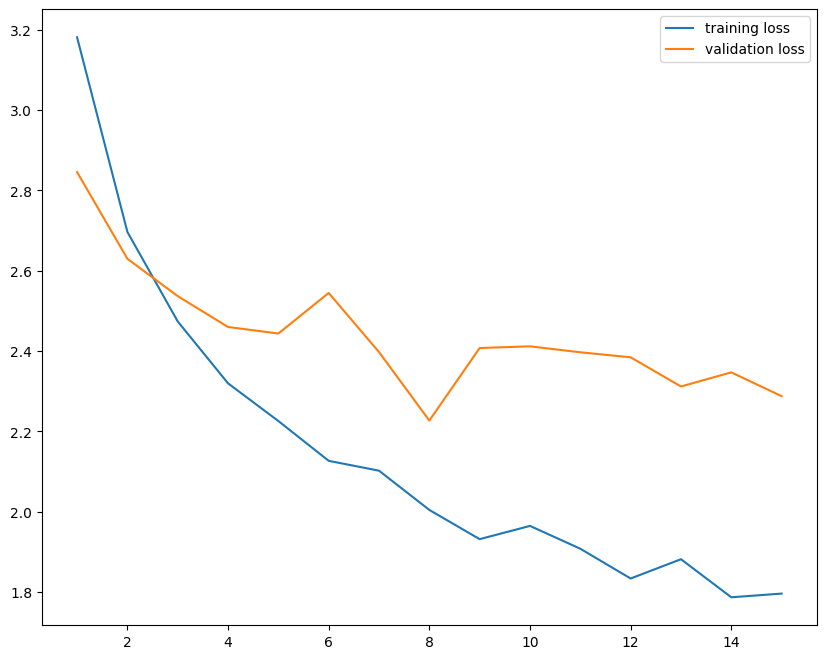

In [19]:
bird_model = models.resnet18()
bird_model.fc=nn.Linear(bird_model.fc.in_features,120)
bird_model.load_state_dict(torch.load('RestNet18_dog_model.pt'))

# for param in bird_model.parameters():
#     param.requires_grad = False
ct = 0
for child in bird_model.children():
    ct += 1
    if ct <= 10:
        for param in child.parameters():
            param.requires_grad = False
    
bird_model.fc=nn.Linear(bird_model.fc.in_features,25)

for param in bird_model.fc.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bird_model = bird_model.to(device)


mean = [0.4914, 0.4822, 0.4465] 
std = [0.2470, 0.2435, 0.2616] 
batch_size = 16
n_epochs = 100

train_transform = transforms.Compose([ 
transforms.Resize((224,224)), 
transforms.RandomCrop(224, padding=4), 
transforms.RandomHorizontalFlip(),
transforms.ToTensor(), 
transforms.Normalize(mean, std)
])

path='C:/Users/User/DeepLearning/Deep_Learning/Bird_Classification/HW2_Dataset/dataset_new'
all_train = datasets.ImageFolder(root = path, transform = train_transform)
train_size = int(0.9 * len(all_train ))
validation_size = len(all_train) - train_size
train_dataset, validation_dataset = random_split(all_train , [train_size, validation_size])

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3
)
val_loader = DataLoader(
    validation_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bird_model.parameters(), lr=1e-3)

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

def train(model, train_loader, optimizer, loss_fn):
    model.train()
    train_loss = 0.
    corrects=0
    total = 0
    for images, labels in tqdm(train_loader):
        optimizer.zero_grad() # step 1
        images = images.to(device)
        labels = labels.to(device)
        

        logits = model(images) # step 2 (forward pass)
        loss = loss_fn(logits, labels) # step 3 (compute loss)
        _, predictions = torch.max(logits, dim=1)
        corrects += predictions.eq(labels).sum().item()
        total += labels.size(0)
        
        loss.backward() # step 4 (backpropagation)
        optimizer.step()

        train_loss += loss.item()*images.size(0)
       
        
    train_loss = train_loss/len(train_loader.sampler)
    
    return train_loss, corrects/total    


@torch.no_grad()
def validate(model, valid_loader, loss_fn):
    model.eval()
    losses=0.
    corrects=0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            
                
            logits = model(images) # step 2 (forward pass)
            loss = loss_fn(logits, labels) # step 3 (compute loss)
            total += labels.size(0)
            
            _, predictions = torch.max(logits, dim=1)
            corrects += predictions.eq(labels).sum().item()
            
            losses += loss.item()*images.size(0)    
            
        valid_loss = losses/len(valid_loader.sampler)
    return valid_loss, corrects / total


# is_valid_available = True
# scheduler = lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.9 ** epoch)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0)

train_loss_list = []
valid_loss_list = []

early_stopper = EarlyStopper(patience=7)

for epoch in range(n_epochs):
    training_loss, training_accuracy = train(bird_model, train_loader, optimizer, loss_fn)
    valid_loss, valid_accuracy = validate(bird_model, val_loader, loss_fn)
    
    train_loss_list.append(training_loss)
    valid_loss_list.append(valid_loss)

    # if scheduler is not None and is_valid_available:
    #     scheduler.step(valid_loss)
    # elif scheduler is not None:
    #     scheduler.step()
    
    if early_stopper.early_stop(valid_loss):
        print(f"Epoch {epoch+1}/{n_epochs}: training accuracy: {training_accuracy}, valid accuracy: {valid_accuracy},train loss: {training_loss},valid loss:{valid_loss}") 
        break

fig, ax = plt.subplots(figsize=(10,8))

ax.plot(range(1, len(train_loss_list)+1), train_loss_list, label="training loss")
ax.plot(range(1, len(valid_loss_list)+1), valid_loss_list, label="validation loss")
ax.legend()        

In [3]:
def R_B_model(num):
    bird_model = models.resnet18()
    bird_model.fc=nn.Linear(bird_model.fc.in_features,120)
    bird_model.load_state_dict(torch.load('RestNet18_dog_model.pt'))

    for param in bird_model.parameters():
        param.requires_grad = False
    ct = 0
    for child in bird_model.children():
        ct += 1
        if ct <= num:
            for param in child.parameters():
                param.requires_grad = True
        
    bird_model.fc=nn.Linear(bird_model.fc.in_features,25)

    for param in bird_model.fc.parameters():
        param.requires_grad = True

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    bird_model = bird_model.to(device)


    mean = [0.4914, 0.4822, 0.4465] 
    std = [0.2470, 0.2435, 0.2616] 
    batch_size = 16
    n_epochs = 100

    train_transform = transforms.Compose([ 
    transforms.Resize((224,224)), 
    transforms.RandomCrop(224, padding=4), 
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), 
    transforms.Normalize(mean, std)
    ])

    path='C:/Users/User/DeepLearning/Deep_Learning/Bird_Classification/HW2_Dataset/dataset_new'
    all_train = datasets.ImageFolder(root = path, transform = train_transform)
    train_size = int(0.9 * len(all_train ))
    validation_size = len(all_train) - train_size
    train_dataset, validation_dataset = random_split(all_train , [train_size, validation_size])

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=3
    )
    val_loader = DataLoader(
        validation_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=3
    )

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(bird_model.parameters(), lr=1e-3)

    class EarlyStopper:
        def __init__(self, patience=1, min_delta=0):
            self.patience = patience
            self.min_delta = min_delta
            self.counter = 0
            self.min_validation_loss = np.inf

        def early_stop(self, validation_loss):
            if validation_loss < self.min_validation_loss:
                self.min_validation_loss = validation_loss
                self.counter = 0
            elif validation_loss > (self.min_validation_loss + self.min_delta):
                self.counter += 1
                if self.counter >= self.patience:
                    return True
            return False

    def train(model, train_loader, optimizer, loss_fn):
        model.train()
        train_loss = 0.
        corrects=0
        total = 0
        for images, labels in tqdm(train_loader):
            optimizer.zero_grad() # step 1
            images = images.to(device)
            labels = labels.to(device)
            

            logits = model(images) # step 2 (forward pass)
            loss = loss_fn(logits, labels) # step 3 (compute loss)
            _, predictions = torch.max(logits, dim=1)
            corrects += predictions.eq(labels).sum().item()
            total += labels.size(0)
            
            loss.backward() # step 4 (backpropagation)
            optimizer.step()

            train_loss += loss.item()*images.size(0)
        
            
        train_loss = train_loss/len(train_loader.sampler)
        
        return train_loss, corrects/total    


    @torch.no_grad()
    def validate(model, valid_loader, loss_fn):
        model.eval()
        losses=0.
        corrects=0
        total = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader):
                images = images.to(device)
                labels = labels.to(device)
                
                    
                logits = model(images) # step 2 (forward pass)
                loss = loss_fn(logits, labels) # step 3 (compute loss)
                total += labels.size(0)
                
                _, predictions = torch.max(logits, dim=1)
                corrects += predictions.eq(labels).sum().item()
                
                losses += loss.item()*images.size(0)    
                
            valid_loss = losses/len(valid_loader.sampler)
        return valid_loss, corrects / total


    # is_valid_available = True
    # scheduler = lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.9 ** epoch)
    # scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0)

    train_loss_list = []
    valid_loss_list = []

    early_stopper = EarlyStopper(patience=7)

    for epoch in range(n_epochs):
        training_loss, training_accuracy = train(bird_model, train_loader, optimizer, loss_fn)
        valid_loss, valid_accuracy = validate(bird_model, val_loader, loss_fn)
        
        train_loss_list.append(training_loss)
        valid_loss_list.append(valid_loss)

        # if scheduler is not None and is_valid_available:
        #     scheduler.step(valid_loss)
        # elif scheduler is not None:
        #     scheduler.step()
        
        if early_stopper.early_stop(valid_loss):
            print(f"Epoch {epoch+1}/{n_epochs}: training accuracy: {training_accuracy}, valid accuracy: {valid_accuracy},train loss: {training_loss},valid loss:{valid_loss}") 
            break

    fig, ax = plt.subplots(figsize=(10,8))

    ax.plot(range(1, len(train_loss_list)+1), train_loss_list, label="training loss")
    ax.plot(range(1, len(valid_loss_list)+1), valid_loss_list, label="validation loss")
    ax.legend()        

100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


Epoch 30/100: training accuracy: 0.5957446808510638, valid accuracy: 0.39669421487603307,train loss: 1.3242772356654404,valid loss:2.1434714301558566


100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Epoch 27/100: training accuracy: 0.6179463459759482, valid accuracy: 0.4380165289256198,train loss: 1.3111134961619628,valid loss:2.1316754739146586


100%|██████████| 8/8 [00:06<00:00,  1.18it/s]


Epoch 27/100: training accuracy: 0.5809435707678076, valid accuracy: 0.47107438016528924,train loss: 1.377068356382527,valid loss:1.9159710229920948


100%|██████████| 8/8 [00:06<00:00,  1.17it/s]


Epoch 17/100: training accuracy: 0.547641073080481, valid accuracy: 0.371900826446281,train loss: 1.5151667938973483,valid loss:2.1093340885540672


100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Epoch 37/100: training accuracy: 0.8917668825161887, valid accuracy: 0.5867768595041323,train loss: 0.38897592694973304,valid loss:1.6476549964305782


100%|██████████| 8/8 [00:06<00:00,  1.18it/s]


Epoch 26/100: training accuracy: 0.9491211840888066, valid accuracy: 0.6776859504132231,train loss: 0.20008668300732763,valid loss:1.1719074377343675


100%|██████████| 8/8 [00:06<00:00,  1.21it/s]


Epoch 20/100: training accuracy: 0.9870490286771508, valid accuracy: 0.6033057851239669,train loss: 0.06332589607516943,valid loss:1.5710824580231975


100%|██████████| 8/8 [00:06<00:00,  1.29it/s]


Epoch 18/100: training accuracy: 0.9444958371877891, valid accuracy: 0.5702479338842975,train loss: 0.17706142507913927,valid loss:1.8163611992331576


100%|██████████| 8/8 [00:06<00:00,  1.23it/s]


Epoch 17/100: training accuracy: 0.967622571692877, valid accuracy: 0.628099173553719,train loss: 0.10732245468685299,valid loss:1.7475776711771311


100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Epoch 24/100: training accuracy: 0.9833487511563367, valid accuracy: 0.6363636363636364,train loss: 0.06343470647703653,valid loss:1.5724661044838015


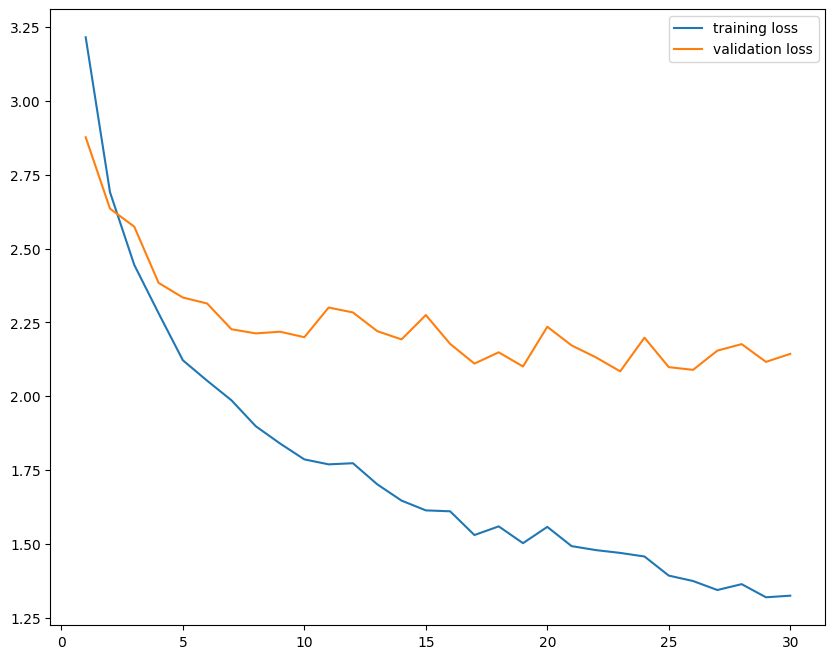

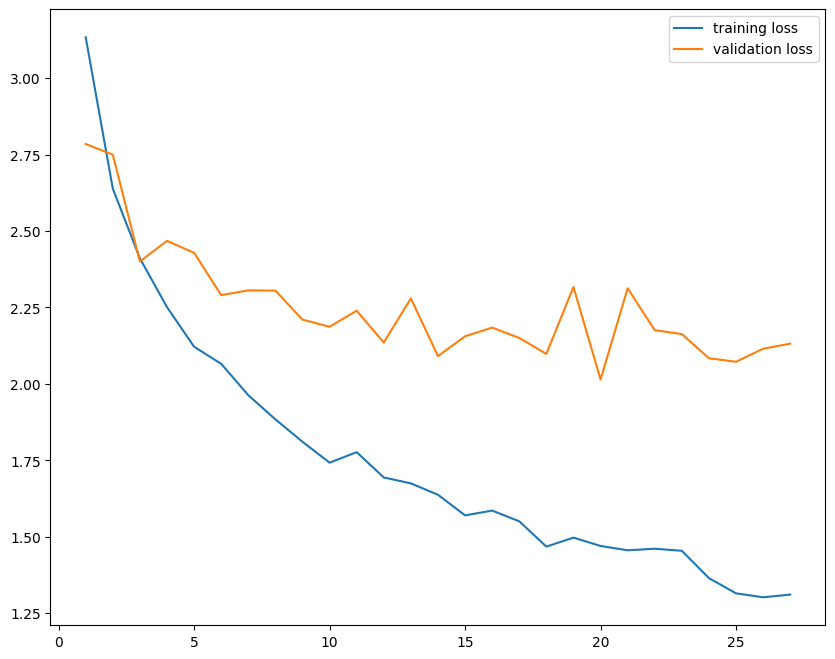

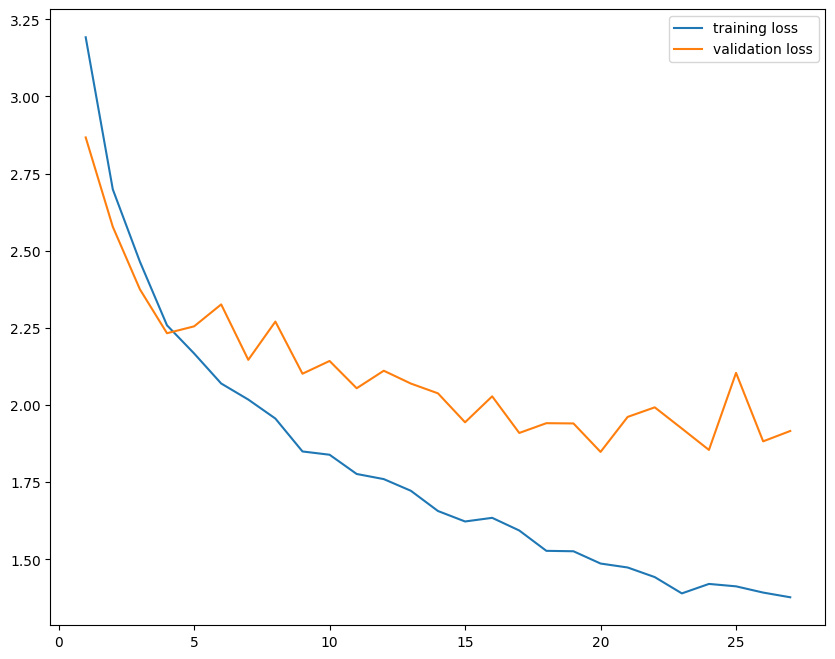

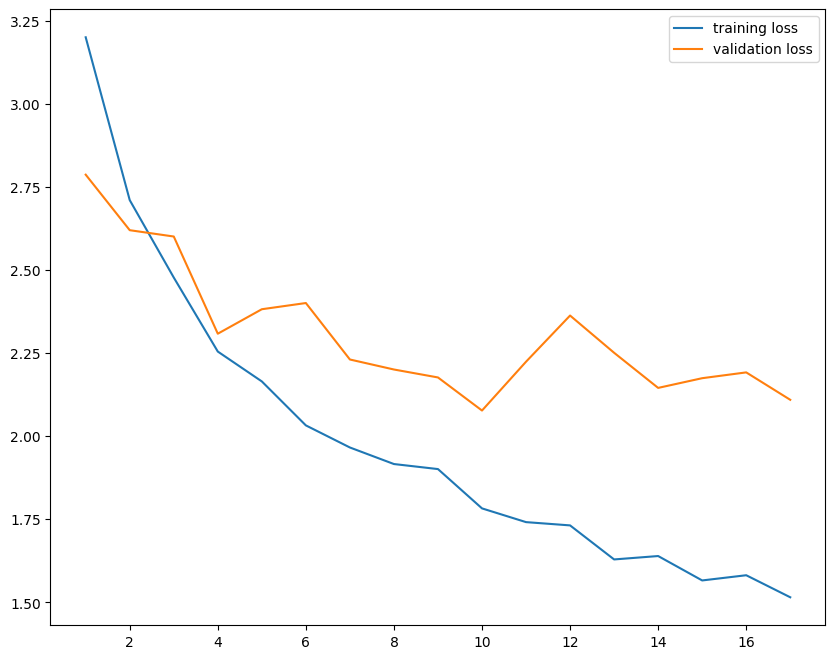

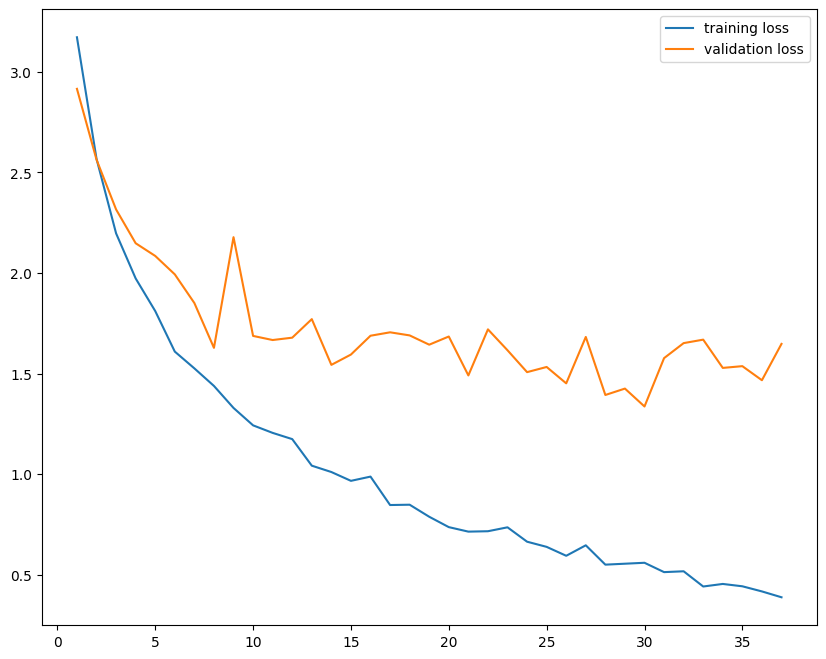

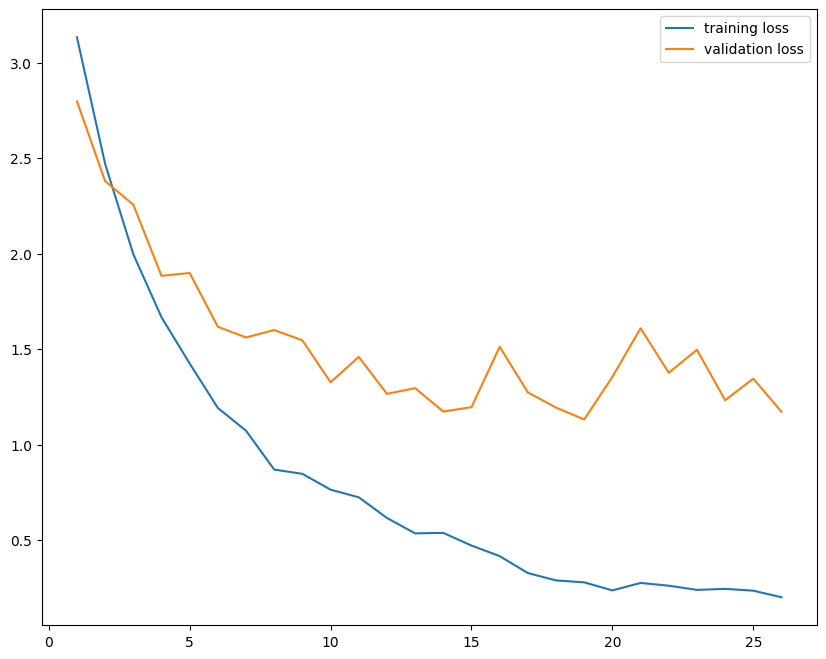

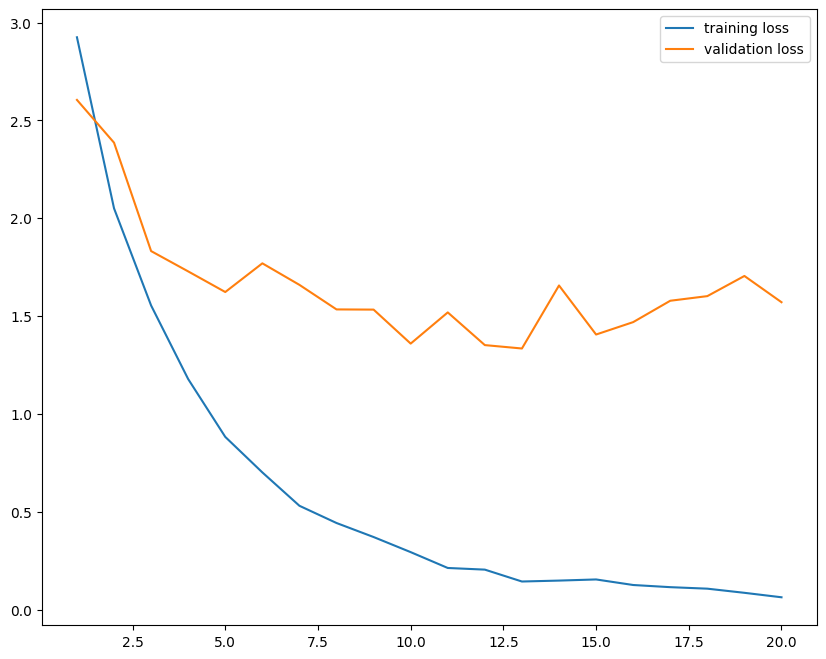

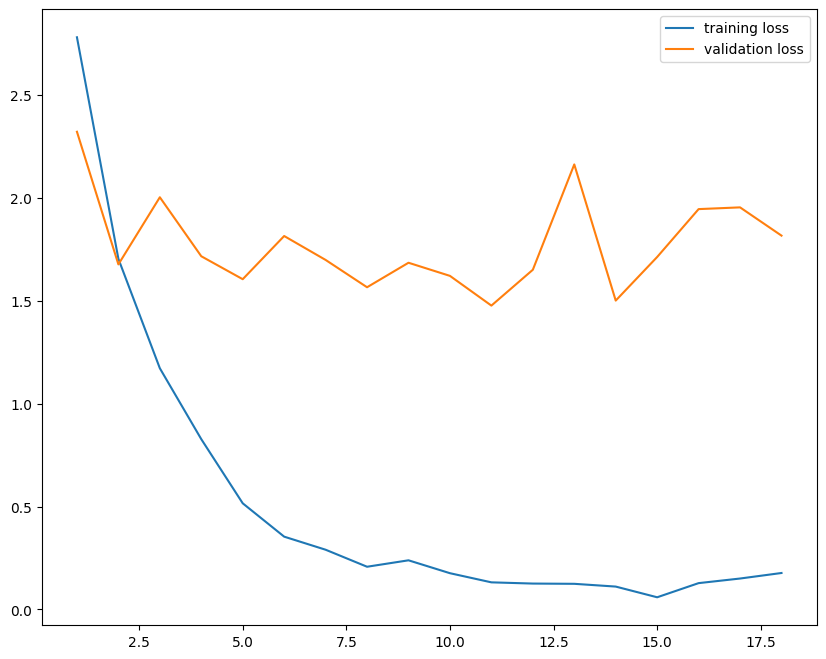

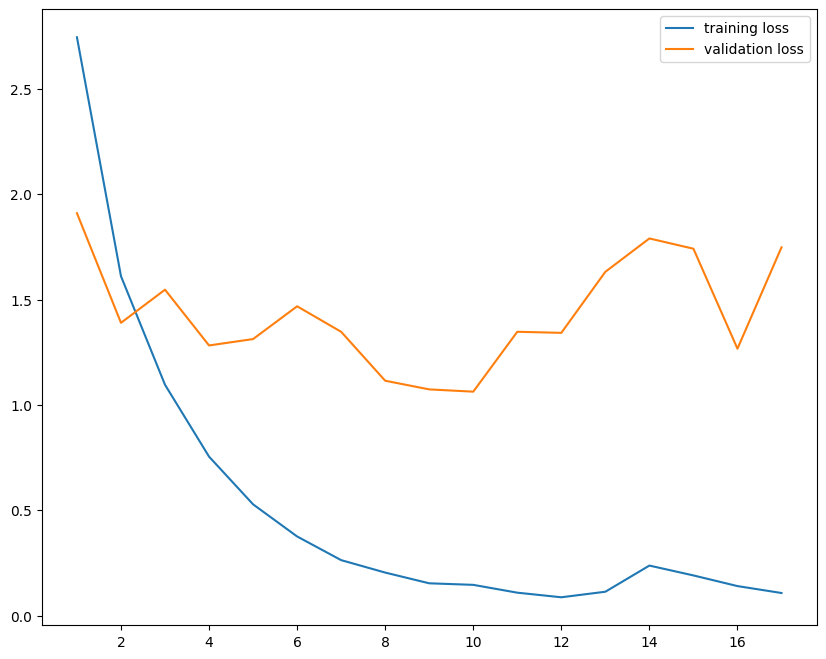

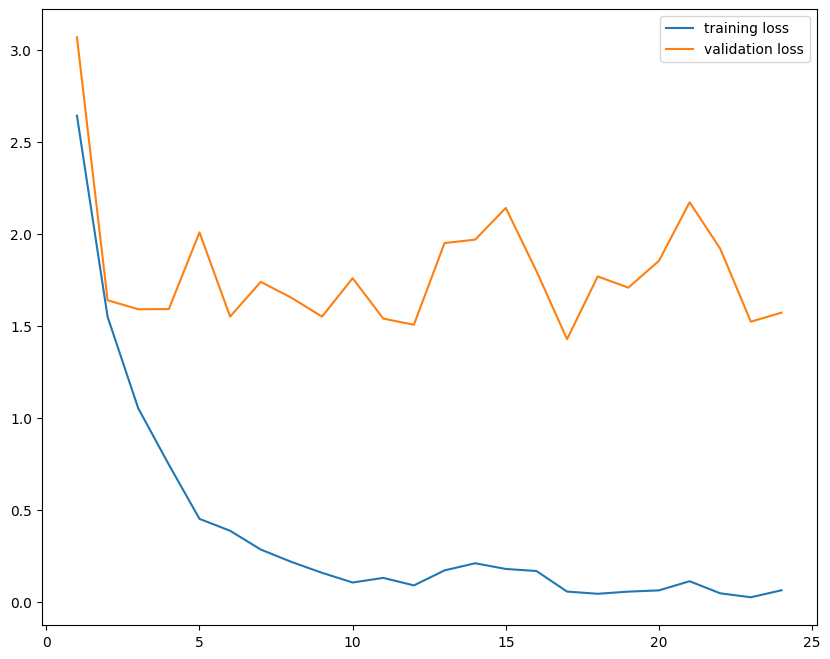

In [4]:
for i in range(1,11):
    R_B_model(i)

c:\Users\User\anaconda3\envs\DeepLearning\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\anaconda3\envs\DeepLearning\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 8/8 [00:06<00:00,  1.22it/s]

Epoch 27/100: training accuracy: 0.9620721554116559, valid accuracy: 0.8347107438016529,train loss: 0.19850712465975265,valid loss:0.6069252382625233


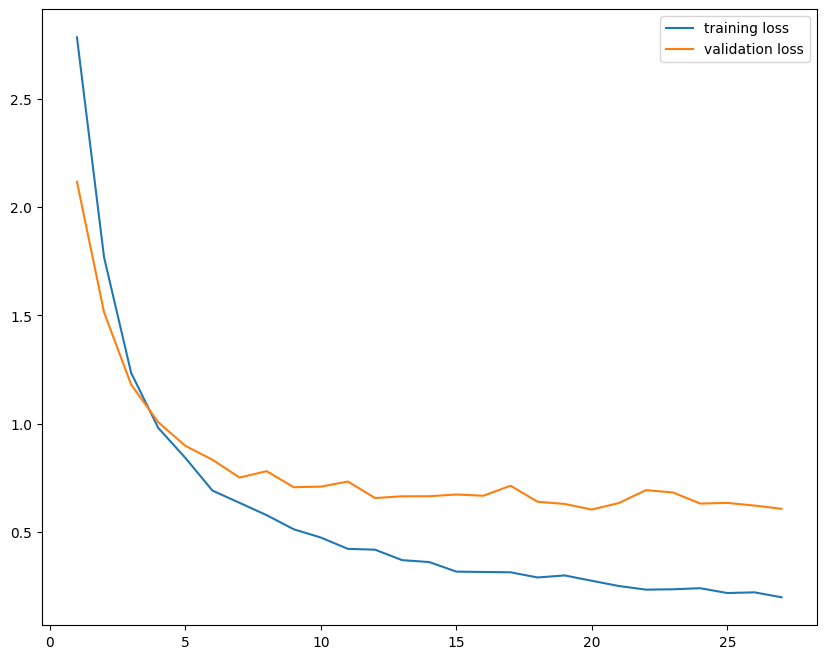

In [13]:
bird_model = models.resnet18(pretrained=True)
# bird_model.fc=nn.Linear(bird_model.fc.in_features,120)
# bird_model.load_state_dict(torch.load('RestNet18_dog_model.pt'))

for param in bird_model.parameters():
    param.requires_grad = False
# ct = 0
# for child in bird_model.children():
#     ct += 1
#     if ct <= 1:
#         for param in child.parameters():
#             param.requires_grad = False
    
bird_model.fc=nn.Linear(bird_model.fc.in_features,25)

for param in bird_model.fc.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bird_model = bird_model.to(device)


mean = [0.4914, 0.4822, 0.4465] 
std = [0.2470, 0.2435, 0.2616] 
batch_size = 16
n_epochs = 100

train_transform = transforms.Compose([ 
transforms.Resize((224,224)), 
transforms.RandomCrop(224, padding=4), 
transforms.RandomHorizontalFlip(),
transforms.ToTensor(), 
transforms.Normalize(mean, std)
])

path='C:/Users/User/DeepLearning/Deep_Learning/Bird_Classification/HW2_Dataset/dataset_new'
all_train = datasets.ImageFolder(root = path, transform = train_transform)
train_size = int(0.9 * len(all_train ))
validation_size = len(all_train) - train_size
train_dataset, validation_dataset = random_split(all_train , [train_size, validation_size])

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3
)
val_loader = DataLoader(
    validation_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bird_model.parameters(), lr=1e-3)

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

def train(model, train_loader, optimizer, loss_fn):
    model.train()
    train_loss = 0.
    corrects=0
    total = 0
    for images, labels in tqdm(train_loader):
        optimizer.zero_grad() # step 1
        images = images.to(device)
        labels = labels.to(device)
        

        logits = model(images) # step 2 (forward pass)
        loss = loss_fn(logits, labels) # step 3 (compute loss)
        _, predictions = torch.max(logits, dim=1)
        corrects += predictions.eq(labels).sum().item()
        total += labels.size(0)
        
        loss.backward() # step 4 (backpropagation)
        optimizer.step()

        train_loss += loss.item()*images.size(0)
       
        
    train_loss = train_loss/len(train_loader.sampler)
    
    return train_loss, corrects/total    


@torch.no_grad()
def validate(model, valid_loader, loss_fn):
    model.eval()
    losses=0.
    corrects=0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            
                
            logits = model(images) # step 2 (forward pass)
            loss = loss_fn(logits, labels) # step 3 (compute loss)
            total += labels.size(0)
            
            _, predictions = torch.max(logits, dim=1)
            corrects += predictions.eq(labels).sum().item()
            
            losses += loss.item()*images.size(0)    
            
        valid_loss = losses/len(valid_loader.sampler)
    return valid_loss, corrects / total


# is_valid_available = True
# scheduler = lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.9 ** epoch)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0)

train_loss_list = []
valid_loss_list = []

early_stopper = EarlyStopper(patience=7)

for epoch in range(n_epochs):
    training_loss, training_accuracy = train(bird_model, train_loader, optimizer, loss_fn)
    valid_loss, valid_accuracy = validate(bird_model, val_loader, loss_fn)
    
    train_loss_list.append(training_loss)
    valid_loss_list.append(valid_loss)

    # if scheduler is not None and is_valid_available:
    #     scheduler.step(valid_loss)
    # elif scheduler is not None:
    #     scheduler.step()
    
    if early_stopper.early_stop(valid_loss):
        print(f"Epoch {epoch+1}/{n_epochs}: training accuracy: {training_accuracy}, valid accuracy: {valid_accuracy},train loss: {training_loss},valid loss:{valid_loss}") 
        break

fig, ax = plt.subplots(figsize=(10,8))

ax.plot(range(1, len(train_loss_list)+1), train_loss_list, label="training loss")
ax.plot(range(1, len(valid_loss_list)+1), valid_loss_list, label="validation loss")
ax.legend()        